In [1]:
# ME EN 4650  Lab2: Spark Ignition    Ryan Dalby    
import numpy as np
from numpy.lib.function_base import interp
import pandas as pd
import matplotlib.pyplot as plt
import os
import matlab.engine # Must install from matlab installation direcotry using: cd "matlabroot\extern\engines\python" && python setup.py install 


In [2]:
# Collected Data 
T_amb = 19 # ambient temperature in lab in deg C
P_atm_mmHg = 786 - 120.6 # barometric pressure in lab (subtraction adjusts for reading being taken in Salt Lake City) in mm Hg
P_atm = P_atm_mmHg * 133.322 # barometric pressure in lab in Pa 
r = 7 # compression ratio (Vbdc_over_Vtdc)
bore = 65.1 # bore in mm
stroke = 44.4 # stroke in mm
timing = 20 # timing relative to TDC in deg
throttle = 100 # throttle in % of fully open
rho_fuel = 726 # fuel density in kg/m^3
LHV = 44.0 # lower heating value (net heating value) in MJ/kg 
n_c = 2.0 # number of revolutions per power stroke
C_v_air = 717 # specific heat at constant volume for air at standard conditions in J/(kg*K)
R_specific_air = 287 # specific gas constant R for air in J/(kg*K)
k = 1.4 # ratio of specific heats of air for standard room temperature values (Cp/Cv) 

# Each index corresponds to each respective experiment
delta_t = np.array([18.23,18.14,19.56,21.08,29.56]) # time interval in s
omega = np.array([2998,2751,2502,2251,2002]) # crankshaft speed in rpm
omega_rad_s = omega*(2*np.pi)/60# crankshaft speed in rad/s
tau = np.array([2.96,3.17,3.30,3.24,3.14]) # torque in Nm
V_fuel = np.array([5.1,5.1,5.1,5.1,5.1]) # fuel consumption in cm^3
V_dot_air = np.array([174,165,163,157,151]) # air flow rate in L/min
V_dot_air_m3_s = V_dot_air * 1.6667e-5 # air flow rate in m^3/s
T_air = np.array([17.4,17.6,17.7,17.9,18.1]) # inlet air temp in deg c
T_fuel = np.array([19.6,20.2,20.5,20.7,21.3]) # fuel temp in deg c
T_exhaust = np.array([531,517,499,480,468]) # exhast air temp in deg c
omega_dryrun = np.array([3004, 2753, 2497, 2248, 2000]) # crankshaft speed for the dry run test in rpm
omega_dryrun_rad_s = omega_dryrun*(2*np.pi)/60# crankshaft for the dry run test speed in rad/s
tau_dryrun = np.array([-2.13, -1.98, -1.85, -1.73, -1.66]) # torque for the dry run test in Nm 

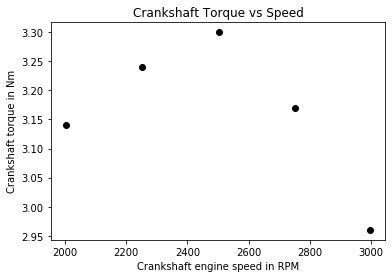

In [3]:
# Figure 1a
plt.figure()
plt.plot(omega, tau, 'ko')
plt.xlabel('Crankshaft engine speed in RPM')
plt.ylabel('Crankshaft torque in Nm')
plt.title('Crankshaft Torque vs Speed')
plt.show()

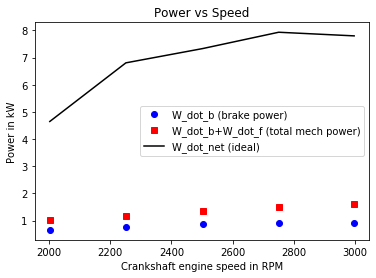

In [4]:
# Figure 1b
W_dot_b = (tau * omega_rad_s)/1000 # brake power in kW
W_dot_f = (tau_dryrun * -1 * omega_dryrun_rad_s)/1000 # power lost from friction and inertia in kW (Note omega and omega_dryrun have slighly different values but are assumed to be same for this)
# omega_vals = np.arange(3000,2000,-10) # omega values for plotting ideal power
rho_inletair = P_atm / (R_specific_air * (T_air+273.15)) # density of the inlet air in kg/m^3
m_dot_air = rho_inletair*V_dot_air_m3_s # mass flow rate of air in kg/s
Q_dot_out = (m_dot_air*C_v_air*(T_exhaust-T_air))/1000 # Heat out of the system in kW
V_dot_fuel = (V_fuel*1e-6) / delta_t # volume flow rate of fuel in m^3/s
m_dot_fuel = rho_fuel * V_dot_fuel # mass flow rate of fuel in kg/s
E_dot_in = (m_dot_fuel * LHV)*1000 # Energy into the system in kW
Q_dot_in = E_dot_in # Heat into the system in kW
W_dot_net = Q_dot_in - Q_dot_out # net power (total mechanical power) in kW 
plt.figure()
plt.plot(omega, W_dot_b, 'bo')
plt.plot(omega, W_dot_b + W_dot_f, 'rs')
plt.plot(omega, W_dot_net, 'k')
plt.legend(['W_dot_b (brake power)', 'W_dot_b+W_dot_f (total mech power)', 'W_dot_net (ideal)'])
plt.xlabel('Crankshaft engine speed in RPM')
plt.ylabel('Power in kW')
plt.title('Power vs Speed')
plt.show()

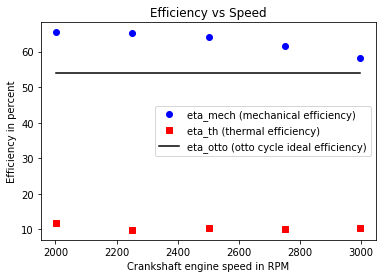

In [5]:
# Figure 1c 
eta_mech = W_dot_b/(W_dot_b+W_dot_f) # mechanical efficiency in fractional form
eta_th = W_dot_b/E_dot_in # thermal efficiency in fractional form
eta_otto = np.full((5,),(1 - 1/(r**(k-1)))) # otto cycle efficiency in fractional form
plt.figure()
plt.plot(omega, eta_mech*100, 'bo')
plt.plot(omega, eta_th*100, 'rs')
plt.plot(omega, eta_otto*100, 'k')
plt.legend(['eta_mech (mechanical efficiency)', 'eta_th (thermal efficiency)', 'eta_otto (otto cycle ideal efficiency)'])
plt.xlabel('Crankshaft engine speed in RPM')
plt.ylabel('Efficiency in percent')
plt.title('Efficiency vs Speed')
plt.show()

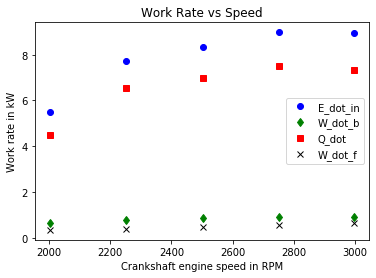

In [6]:
# Figure 1d
Q_dot = E_dot_in - (W_dot_b+W_dot_f) # All heat rejected to surroundings in kW

plt.figure()
plt.plot(omega, E_dot_in, 'bo')
plt.plot(omega, W_dot_b, 'gd')
plt.plot(omega, Q_dot, 'rs')
plt.plot(omega, W_dot_f, 'kx')
plt.legend(['E_dot_in', 'W_dot_b', 'Q_dot', 'W_dot_f'])
plt.xlabel('Crankshaft engine speed in RPM')
plt.ylabel('Work rate in kW')
plt.title('Work Rate vs Speed')
plt.show()

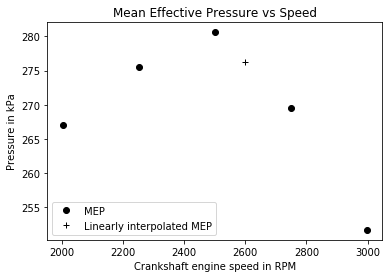

In [7]:
# Figure 1e
V_d = np.pi * ((bore/1000)/2)**2 * (stroke/1000) # volumetric displacement in m^3
MEP = ((tau * 2 * np.pi * n_c)/V_d)/1000 # mean effective pressure in kPa
plt.figure()
plt.plot(omega, MEP, 'ko')
interp_m, interp_b = np.polyfit(omega[1:3], MEP[1:3], 1) # Linearly interpolated MEP at 2600 rpm
MEP_2600_interp = interp_m*2600+interp_b # Interpolated MEP at 2600 RPM in kPa
plt.plot(2600, MEP_2600_interp, 'k+')
plt.legend(['MEP', 'Linearly interpolated MEP'])
plt.xlabel('Crankshaft engine speed in RPM')
plt.ylabel('Pressure in kPa')
plt.title('Mean Effective Pressure vs Speed')
plt.show()

In [8]:
# 2a
print('Average W_dot_b/E_dot_in = {:.2f}%'.format(np.average(W_dot_b/E_dot_in)*100))
print('Average W_dot_f/E_dot_in = {:.2f}%'.format(np.average(W_dot_f/E_dot_in)*100))
print('Average Q_dot/E_dot_in = {:.2f}%'.format(np.average(Q_dot/E_dot_in)*100))

Average W_dot_b/E_dot_in = 10.56%
Average W_dot_f/E_dot_in = 6.25%
Average Q_dot/E_dot_in = 83.20%


In [9]:
# 2b
print('Average mechanical efficiency of the engine is {:.2f}'.format(np.average(eta_mech)))
epsilon = np.average((eta_otto - eta_th)/eta_otto)*100
print('The discrepancy between the thermal efficiency and the Otto cycle efficiency was on average {:.2f}%'.format(epsilon))

Average mechanical efficiency of the engine is 0.63
The discrepancy between the thermal efficiency and the Otto cycle efficiency was on average 80.48%


In [10]:
# 2c
print('The estimated MEP at 2600 RPM is {:.2f}kPa'.format(MEP_2600_interp))
MEP_2600_interp_force_N = (np.pi*((bore/1000)**2) * MEP_2600_interp) * 1000 # Estimated average force on piston head at 2600 RPM in N
MEP_2600_interp_force_lb = MEP_2600_interp_force_N * 0.22480894387 # Estimated average force on piston head at 2600 RPM in lb
print('This corresponds to an average force of {:.2f}N or {:.2f}lb'.format(MEP_2600_interp_force_N,MEP_2600_interp_force_lb))

The estimated MEP at 2600 RPM is 276.25kPa
This corresponds to an average force of 3678.02N or 826.85lb
